### Regression Exercise 
# Moneyball The NBA
---

# Rough Guide a v1 model.
0. Make a model to predict PTS 
0. For v1, dont use `2P, 3P, FG, or FT`.  Instead use `2PA, 3PA, FTA`.  
0. Include any other cols use see fit.  


In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

import CTPLIB as ctp

from skimpy import skim, generate_test_data

In [23]:
df = pd.read_csv('data/NBA_train.csv')
df.dropna(inplace=True)

<Axes: xlabel='W', ylabel='Playoffs'>

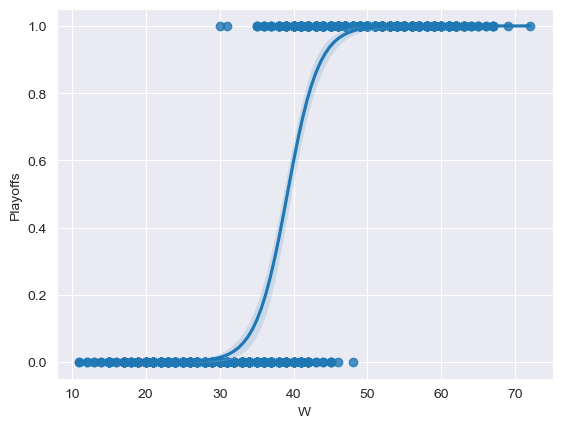

In [24]:
sns.regplot(data=df, x='W', y='Playoffs', logistic=True)

Let Y represent the event of a team making the playoffs. The expression P(Y | W) represents the likelihood a team making the playoffs given W wins.

The bottom and top horizontal lines represent:
- Teams that did not make the playoffs P(Y | W) = 0
- Teams that did make the playoffs P(Y | W) = 1

The logistic regression curve shows that the playoff probability increases exponentially at P(Y | W >= 30) and reaches near certainty at P(Y | W >= 50).
___

To model P(Y | W) we first need to predict the number of Wins. Let's start by filtering out noisy columns (ie. dates and team names) that do not contribute to teams winning.

Additionally, target columns (ie. points, playoffs) must be filtered out, as they indicate a team's performance rather than the underlying factors that drive it.

In [25]:
y = df['PTS']
columns_to_drop = ['PTS', '2P', '3P', 'FG', 'FT', 'SeasonEnd', 'Team', 'Playoffs', 'W']
X = df.drop(columns=columns_to_drop)

skim(X)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 835    │ │ int64       │ 11    │                                                          │
│ │ Number of columns │ 11     │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0     ┃ p25     ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ oppPTS          │   0 │      0 │    8370 │   587.5 │   6909 │    7934 │   8365 │   8768 │  10720 │  ▂▇▇▅▁  │  │
│ │ FGA             │   0 │      0 │    6873 │     401 │   5972 │    6564 │   6831 │   7157 │   8868 │  ▃▇▆▁   │  │
│ │ 2PA             │   0 │      0 │    5956 │   830.6 │   4153 │    5269 │   5706 │   6754 │   7873 │ ▁▇▆▃▆▂  │  │
│ │ 3PA             │   0 │      0 │   916.9 │     524 │     75 │     413 │    942 │   1348 │   2284 │ ▇▅▇▇▃▁  │  │
│ │ FTA             │   0 │      0 │    2190 │   244.5 │   1475 │    2008 │   2176 │   2352 │   3051 │  ▁▅▇▆▂  │  │
│ │ ORB             │   0 │      0 │    1062 │   150.2 │    639 │   953.5 │   1055 │   1167 │   1520 │   ▅▇▆▃  │  │
│ │ DRB             │   0 │      0 │    2427 │   130.7 │   2044 │    2346 │   2433 │   2516 │   2753 │ ▁▂▆▇▅▁  │  │
│ │ AST             │   0 │      0 │    1912 │   221.6 │   1423 │    1735 │   1899 │   2078 │   2575 │  ▂▇▇▇▃  │  │
│ │ STL             │   0 │      0 │   668.4 │   93.39 │    455 │     599 │    658 │    729 │   1053 │  ▂▇▇▃▁  │  │
│ │ BLK             │   0 │      0 │   419.8 │   82.27 │    204 │     359 │    410 │  469.5 │    716 │  ▁▅▇▅▁  │  │
│ │ TOV             │   0 │      0 │    1303 │     154 │    931 │    1192 │   1289 │   1396 │   1873 │  ▁▇▇▃▁  │  │
│ └─────────────────┴─────┴────────┴─────────┴─────────┴────────┴─────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Column definitions:

- oppPTS: Opponent points (points allowed by the team)
- FGA, 2PA, 3PA, FTA: Field goals attempted, two-point attempts, three-point attempts, free throw attempts
- ORB, DRB: Offensive rebounds, Defensive rebounds
- AST, STL, BLK, TOV: Assists, Steals, Blocks, Turnovers